# Process, Clean, and Save all Auxiliary Data Sets  
-> Only run this once, then load the pickle file in analysis notebooks to avoid redundancy
__________
#### This notebook does the following:
1.   Clean CDEC snow depth data  
2.   Create a GDF of CDEC station locations with 5km radius polygons  
3.   Clean Tuolumne Outline file  
4.   Clip California Lakes file to the Tuolumne River Basin above Hetch Hetchy  
5.   Make major streamlines file for plotting  
6.   Make dataframe with all ASO flight dates for ATL06-SR/ASO pair determination

In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import pickle
from astropy.time import Time
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import rioxarray as rxr
from scipy.signal import savgol_filter

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

## 1. Clean CDEC Data and Save to Pickle

## Load CDEC Snow Depth for same date range and add to time series  

In [32]:
tum = pd.read_csv('../data/CDEC/TUM_18.csv')
dan = pd.read_csv('../data/CDEC/DAN_18.csv')

tum = tum.rename(columns={'OBS DATE':'OBS_DATE', 'DATE TIME':'DATE_TIME'})
dan = dan.rename(columns={'OBS DATE':'OBS_DATE', 'DATE TIME':'DATE_TIME'})

In [33]:
tum_elev = 2621.28
dan_elev = 2965

In [34]:
# from stack overflow

from datetime import date


def int2date(argdate: int) -> date:
    """
    If you have date as an integer, use this method to obtain a datetime.date object.

    Parameters
    ----------
    argdate : int
      Date as a regular integer value (example: 20160618)

    Returns
    -------
    dateandtime.date
      A date object which corresponds to the given value `argdate`.
    """
    year = int(argdate / 10000)
    month = int((argdate % 10000) / 100)
    day = int(argdate % 100)

    return date(year, month, day)

#### Fill in Nan values so OBS_DATE can be converted to DateTimeIndex  
I found the locations where this column was Nan, and then used the dates on either side to fill in.

In [35]:
tum.loc[126, 'OBS_DATE'] = 20190204.0
tum.loc[134, 'OBS_DATE'] = 20190212.0
tum.loc[394, 'OBS_DATE'] = 20191030.0

#### Convert snow depth from inches to meters, convert time to datetime index, and add day of year (doy):

In [36]:
snwd = pd.DataFrame([tum.OBS_DATE, tum.VALUE]).transpose()
snwd.VALUE = snwd.VALUE * 2.54/100
snwd = snwd.rename(columns={'VALUE':'tum_m'})
snwd['dan_m'] = dan.VALUE * 2.54/100

snwd['Date'] = snwd['OBS_DATE'].map(lambda x: int(x))
snwd['Date'] = pd.DatetimeIndex(snwd['Date'].map(lambda x: int2date(x)))

snwd = snwd.set_index('Date')
snwd.sort_index(inplace=True)
snwd = snwd.drop(columns=['OBS_DATE'])
add_dowy(snwd)

Adding Day of Water Year (DOWY)


In [12]:
#snwd = snwd[snwd['tum_m'] < 2.9]

In [13]:
snwd.head(2)

,tum_m,dan_m,doy,decyear,dowy
Date,,,,,
2018-10-01,0.0254,-0.0508,274,2018.747945,1
2018-10-02,0.0000,NaN,275,2018.750685,2


### Plot the raw data:

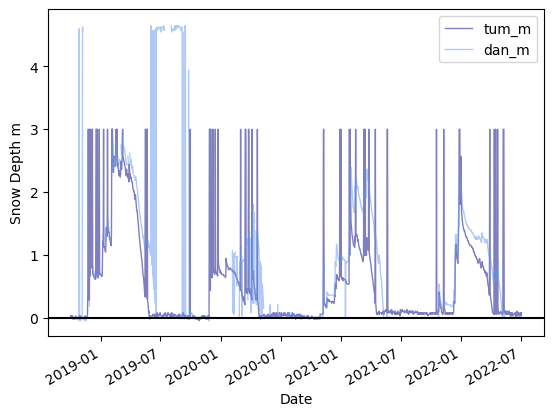

In [38]:
fig, ax = plt.subplots()
snwd['tum_m'].plot(alpha=0.5, color='navy', lw=1)
snwd['dan_m'].plot(alpha=0.5, color='cornflowerblue', lw=1)
ax.axhline(y = 0, c = 'k')
plt.ylabel('Snow Depth m')
plt.legend()

### Remove the upper outliers (>2.99 m) and plot:

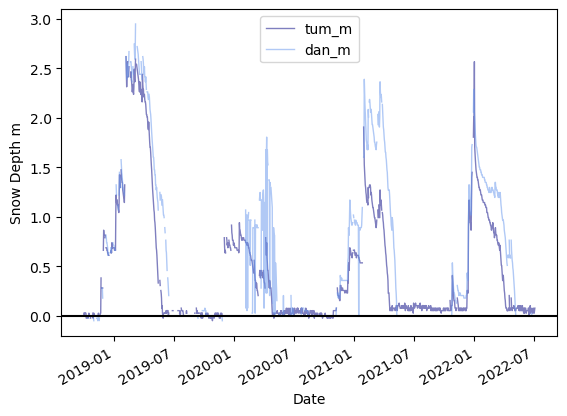

In [40]:
# Get rid of the problem data, that all appear to be above 2.99m
snwd[snwd['tum_m']>2.99] = np.nan
snwd[snwd['dan_m']>2.99] = np.nan

fig, ax = plt.subplots()
snwd['tum_m'].plot(alpha=0.5, color='navy', lw=1)
snwd['dan_m'].plot(alpha=0.5, color='cornflowerblue', lw=1)
ax.axhline(y = 0, c = 'k')
plt.ylabel('Snow Depth m')
plt.legend()

### Save an intermediate file of the combined data:

In [51]:
# Save the combined geodataframe of the two cdec sites as an intermediate file

out_fn = '../data/CDEC/cdec_gdf.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(snwd, f)

### Clean Dana Meadows CDEC data:    
* Make a new dataframe of only dana, so that I can remove outliers. 
* Fit a smoothed line to the data. 
* Offset this smoothed line so that values below the line appear to be mistakes in the data, and above the line is data we want to preserve.   

In [6]:
# Can skip to this step by loading in the file created above:

#snwd = pickle.load(open('../data/CDEC/cdec_gdf.pkl', 'rb'))

### Isolate the Dana Meadows data:

In [41]:
dana_df = pd.DataFrame([snwd.index, snwd.dan_m]).transpose()
dana_df = dana_df.rename(columns={0:'date', 1:'dan_m'})
dana_df = dana_df.set_index('date')
dana_df = dana_df.dropna()
dana_df.head()

,dan_m
date,
2018-10-01,-0.0508
2018-10-08,-0.0254
2018-10-10,-0.0254
2018-10-14,-0.0254
2018-10-15,-0.0254


### Fit a smoothing line to the Dana data:

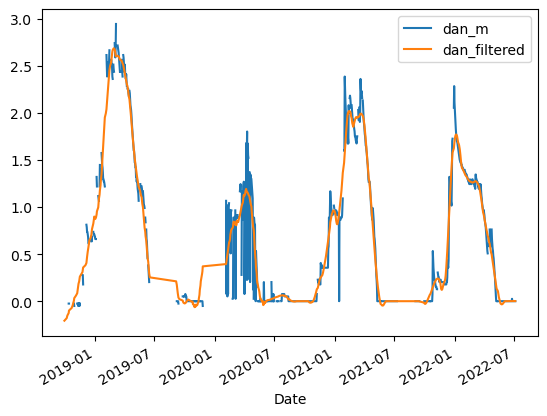

In [42]:
# Apply the smoothing function
dana_df['dan_filtered'] = savgol_filter(dana_df['dan_m'], 50, 2)
snwd['dan_filtered'] = dana_df['dan_filtered']

fig, ax = plt.subplots()
snwd['dan_m'].plot(ax=ax)
snwd[snwd['dan_m']<2.99]['dan_filtered'].plot(ax=ax)
plt.legend()

### Offset the smoothed line by -0.3 m:

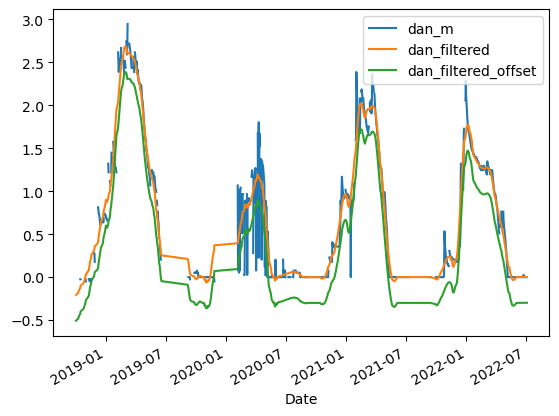

In [43]:
# Offset the smoothed function
snwd['dan_filtered_offset'] = snwd['dan_filtered'] - 0.3

fig, ax = plt.subplots()
snwd['dan_m'].plot(ax=ax)
snwd[snwd['dan_m']<2.99]['dan_filtered'].plot(ax=ax)
snwd[snwd['dan_m']<2.99]['dan_filtered_offset'].plot(ax=ax)
plt.legend()

### Remove lower outliers from Dana data, defined as values below the offset filter:
And add this cleaned data to the dataframe containing both DAN and TUM data.

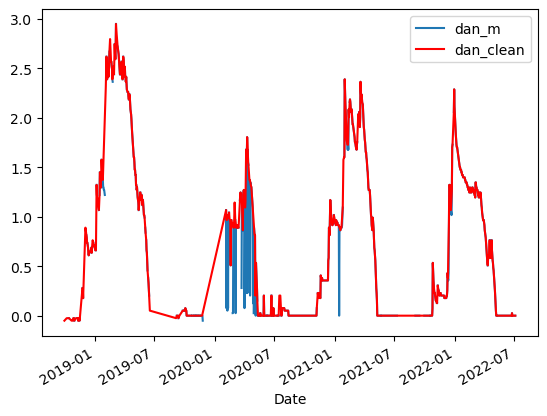

In [44]:
snwd['dan_clean'] = np.nan
for i in range(len(snwd)):
    if snwd['dan_m'][i] > snwd['dan_filtered_offset'][i]:
        snwd['dan_clean'][i] = snwd['dan_m'][i]

fig, ax = plt.subplots()
snwd['dan_m'].plot(ax=ax)
snwd[snwd['dan_clean']<2.99]['dan_clean'].plot(ax=ax, color='r')
plt.legend()

### Remove a single date of erroneous data at Dana that was bothering me:

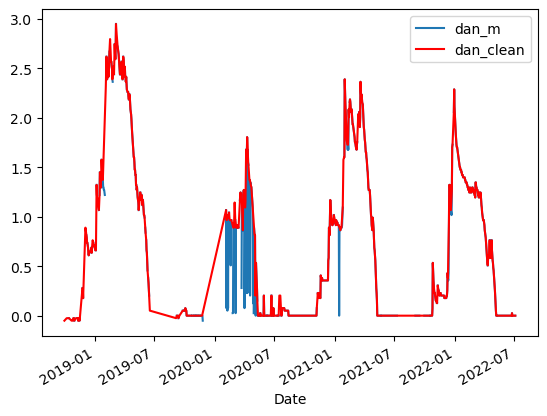

In [45]:
snwd.loc['2020-02-19', 'dan_clean'] = np.nan

fig, ax = plt.subplots()
snwd['dan_m'].plot(ax=ax)
snwd[snwd['dan_clean']<2.99]['dan_clean'].plot(ax=ax, color='r')
plt.legend()

### Remove the unnecessary columns that were used for filtering:

In [46]:
snwd = snwd.drop(columns=['dan_filtered', 'dan_filtered_offset'])

### Save this final version of the cleaned dataset:

In [69]:
# Save the combined geodataframe of the two cdec sites, 
# overwriting the previously saved intermediate file:

out_fn = '../data/CDEC/cdec_gdf.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(snwd, f)

## 2. Create GDF of CDEC Coordinates and Radius 

In [77]:
# Set elevation and coordinates of the CDEC sites:

tum_elev = 2621.28
dan_elev = 2965

tum_coords = [37.873000,-119.350000]
dan_coords = [37.897000,-119.257000]

#tum_band = [2371.28, 2871.28]
#dan_band = [2715,3215]

In [78]:
dan_elev - 250

2715

### Create 5 km radius around TUM CDEC site

In [92]:
# Create a transform that will go from the native ICESat-2 and Snotel CS (4326) 
# to the common projection we will use (32610, ie UTM Zone 10 N)

target_crs = "EPSG:32611"
from pyproj import Transformer,CRS
to_target_crs = Transformer.from_crs(4326,target_crs)

In [93]:
# Transform the snotel site locations to 32610
# Originally written by Hannah for Methow notebook

points_cdec = []
cdec_coords = [(37.873000,-119.350000,2621.28),(37.897000,-119.257000,2965)]
for pt in to_target_crs.itransform(cdec_coords):
    points_cdec.append(pt)
x_cdec = [x_tuple[0] for x_tuple in points_cdec]
y_cdec = [y_tuple[1] for y_tuple in points_cdec]
z_cdec = [z_tuple[2] for z_tuple in points_cdec]
cdec_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x_cdec, y_cdec), crs='epsg:32611')
cdec_gdf['elevation_m'] = z_cdec

### Plot the sites:

<AxesSubplot: >

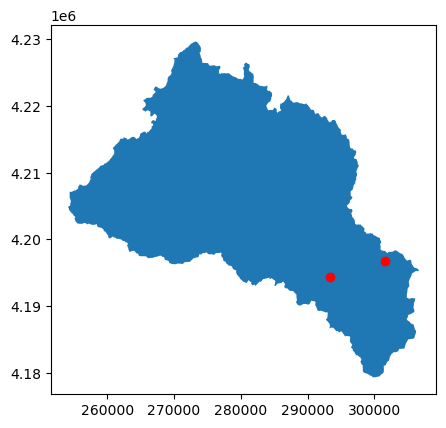

In [94]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_gdf.plot(ax=ax, c='r')

In [95]:
# Label the sites:

cdec_gdf['site'] = ''
cdec_gdf.loc[0, 'site'] = 'tum'
cdec_gdf.loc[1, 'site'] = 'dan'
cdec_gdf

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan


In [96]:
# Make shapely points from the gdf coordinates to use in radius creation:

from shapely.geometry import Point

tum = Point((cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.x, cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.y))
dan = Point((cdec_gdf[cdec_gdf['site'] == 'dan'].geometry.x, cdec_gdf[cdec_gdf['site'] == 'dan'].geometry.y))

In [97]:
# Make a new dataframe for the radius creation:

df_center= pd.DataFrame({'site':'tum_5km','geometry':[tum]})
df_center.loc[len(df_center)]={'site':'dan_5km', 'geometry':dan}
df_center

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/construction.py:810: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)


,site,geometry
0,tum_5km,POINT (293306.5622950811 4194327.334556827)
1,dan_5km,POINT (301551.8767049168 4196788.618859532)


In [98]:
# create a buffer around the station points:

gdf_center = gpd.GeoDataFrame(df_center, geometry=df_center['geometry'], crs='epsg:32611')
gdf_center['geometry'] = gdf_center.geometry.buffer(5000)
gdf_center

,site,geometry
0,tum_5km,"POLYGON ((298306.562 4194327.335, 298282.486 4..."
1,dan_5km,"POLYGON ((306551.877 4196788.619, 306527.800 4..."


<AxesSubplot: >

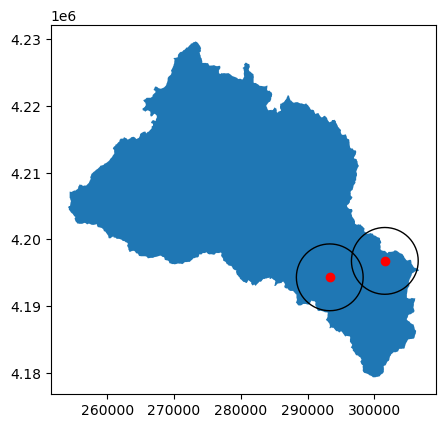

In [99]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_gdf.plot(ax=ax, c='r')
gdf_center.plot(ax=ax, facecolor='none')

## Combine the point and polygon geodataframes:

In [100]:
cdec_geom = pd.concat([cdec_gdf, gdf_center], ignore_index=True)
cdec_geom

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan
2,"POLYGON ((298306.562 4194327.335, 298282.486 4...",NaN,tum_5km
3,"POLYGON ((306551.877 4196788.619, 306527.800 4...",NaN,dan_5km


### Recreate the above plot from the combined geodataframe:

<AxesSubplot: >

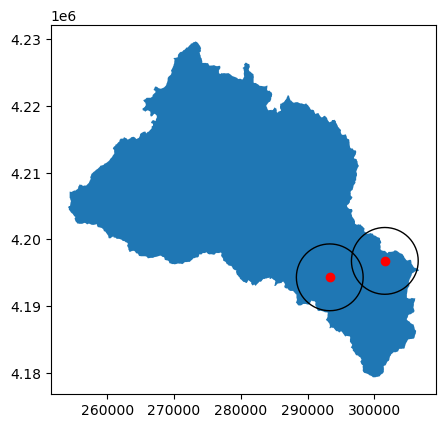

In [101]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_geom[cdec_geom.geometry.geom_type == 'Point'].plot(ax=ax, color='r')
cdec_geom[cdec_geom.geometry.geom_type == 'Polygon'].plot(ax=ax, facecolor='none', edgecolor='k')
# cdec_gdf.plot(ax=ax, c='r')
# gdf_center.plot(ax=ax, facecolor='none')

In [102]:
cdec_geom.crs

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Save the point and radius geodataframe:

In [103]:
cdec_out_fn = '../data/CDEC/cdec_geometries.pkl'

with open(cdec_out_fn, 'wb') as f:
    pickle.dump(cdec_geom, f)

## 3. Clean the Tuolumne Outline file

In [34]:
outline_gdf = gpd.read_file('../data/UpperTuolRiverBasinOutline.geojson')
outline_gdf = outline_gdf[0:1]
outline_gdf = outline_gdf.to_crs('EPSG:32611')

outline_fn = '../../data/site_outlines/tuolumne_outline_32611'

with open(outline_fn, 'wb') as f:
    pickle.dump(outline_gdf, f)

## 4. Clip Lakes to Tuolumne 

### Read in the outline file created above:

In [10]:
outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))

### Read in the California Lakes dataset:  
from https://data.cnra.ca.gov/dataset/california-lakes

In [27]:
lakes = gpd.read_file('../../data/site_outlines/California_Lakes.geojson')

### Transform to UTM Zone 11N:

In [29]:
lakes = lakes.to_crs('EPSG:32611')

### Clip CA lakes to the Tuolumne River Basin above Hetch Hetchy:

In [36]:
lakes = gpd.clip(lakes, outline_gdf)

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

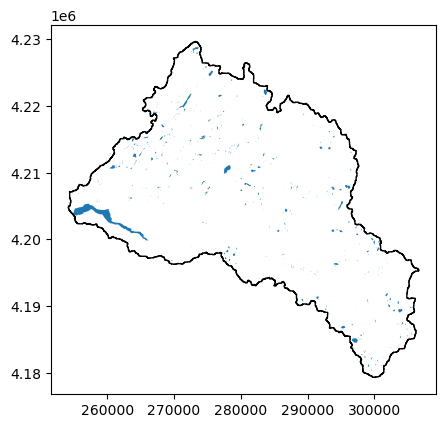

In [37]:
fig, ax = plt.subplots()

lakes.plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none')

### Save the clipped lakes file:

In [38]:
out_fn = '../../data/site_outlines/lakes_tuolumne.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(lakes, f)

## Save a polygon of Hetch Hetchy Reservoir:

In [ ]:
hetch = lakes[lakes['NAME']=='Hetch Hetchy Reservoir']
hetch = hetch.to_crs('EPSG:32611')

# Save the Hetch Hetchy file

out_fn = '../../../data/misc/hetch_hetchy.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(hetch, f)

## 5. Clip Streamlines to Tuolumne

### Load the outline file created in step 3:

In [54]:
outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))

### Load NHD major rivers and creeks file:

In [51]:
nhd = gpd.read_file('../../data/misc/nhd_major_rivers_and_creeks')

### Transform to UTM Zone 11N:

In [58]:
nhd = nhd.to_crs('epsg:32611')

In [59]:
nhd.crs

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Clip to Tuolumne River Basin above Hetch Hetchy:

In [61]:
streamlines_tuol = gpd.clip(nhd, outline_gdf)

### Plot the new major streamline GDF:

<AxesSubplot: >

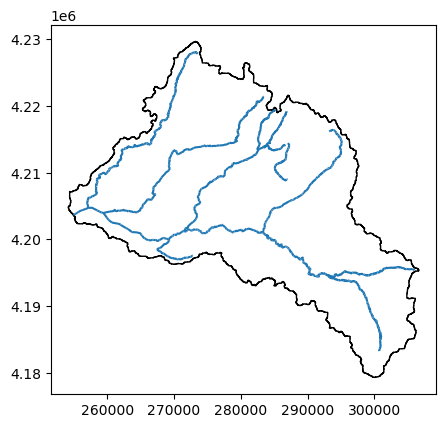

In [62]:
fig, ax = plt.subplots()
streamlines_tuol.plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

## 6. Create ASO GDF with Temporal Data for Plotting

### Clip and save all ASO snow-on files to study area

In [121]:
aso_dir = '../../data/lidar/tuolumne/snow_on/coarse_20m'
aso_fn_list = !ls $aso_dir/ASO*.tif
aso_fn_list

['../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190705_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20200507_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220228_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220429_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220518_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdep

In [122]:
len(aso_fn_list)

14

In [123]:
#aso_fn_list.pop(-1)

In [124]:
# Code adapted from David Shean's code, from Grand Mesa analysis presumably

aso_feat_list = []
ovr_scale = 8
dt_fieldnum = -2
for fn in aso_fn_list:
    src = rio.open(fn)
    a = src.read(1, masked=True, out_shape=(src.count, int(src.height / ovr_scale), int(src.width / ovr_scale)))
    ovr_transform = src.transform * src.transform.scale(src.width / a.shape[-1], src.height / a.shape[-2])
    mask = np.ma.getmaskarray(a).astype(np.uint8) - 1
    shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
    geom_list = list(shapes)
    dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[dt_fieldnum]
    aso_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])

In [125]:
aso_gdf = gpd.GeoDataFrame.from_features(aso_feat_list, crs=src.crs)
#aso_gdf = aso_gdf.to_crs(crs)

In [126]:
aso_gdf.tail(2)

,geometry,fn,date
20,"POLYGON ((242718.000 4234845.000, 242718.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,20200522
21,"POLYGON ((212352.000 4234641.000, 212352.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,20210429


In [127]:
area_thresh = 1e8
aso_gdf = aso_gdf.loc[aso_gdf.area > area_thresh]

In [128]:
aso_gdf['date'] = pd.to_datetime(aso_gdf['date'])

In [129]:
aso_gdf['platform'] = 'ASO'

In [130]:
add_dowy(aso_gdf, col='date')
aso_gdf.set_index('date', inplace=True)
aso_gdf['acqdate'] = aso_gdf.index.date

Adding Day of Water Year (DOWY)


In [131]:
aso_gdf['site'] = 'tuolumne'

In [132]:
aso_gdf.head()

,geometry,fn,platform,doy,decyear,dowy,acqdate,site
date,,,,,,,,
2019-03-24,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,83,2019.224658,175,2019-03-24,tuolumne
2019-04-17,"POLYGON ((254726.111 4234848.000, 259690.704 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,107,2019.290411,199,2019-04-17,tuolumne
2019-05-03,"POLYGON ((254726.111 4234848.000, 259690.704 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,123,2019.334247,215,2019-05-03,tuolumne
2019-07-05,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,186,2019.506849,278,2019-07-05,tuolumne
2020-05-07,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,128,2020.346995,220,2020-05-07,tuolumne


In [135]:
aso_fn = '../../data/aso_dates.pkl'

with open(aso_fn, 'wb') as f:
    pickle.dump(aso_gdf, f)

In [104]:
aso_fn_dates = ['../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190324.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190417.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190503.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190705.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_snowdepth_3m_20200413.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_snowdepth_3m_20200522.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_50m_20210225.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204.tif',
                 '../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405.tif']

In [86]:
# Adapted from David Shean's code
# not the original - changing to try and make applicable to specific dates of ASO/Is2 overlap

def sample_raster_dates(df, src, diff_col=None, date=datetime.date(2019, 3, 12)):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.loc[df['acqdate'] == date].to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    df.loc[df['acqdate'] == date, 'ASO_snowon'] = sm
    dt_str = os.path.splitext(os.path.split(src.name)[-1])[-2].split('_')[-1]
    df.loc[df['acqdate'] == date, 'ASO_snowon_date'] = datetime.datetime.strptime(dt_str, '%Y%m%d').date()

In [87]:
atl06sr_gdf['ASO_snowon'] = pd.Series(dtype=float)
atl06sr_gdf['ASO_snowon_date'] = pd.Series(dtype=float)

for file, date in zip(aso_fn_dates, atl06_dates):
    src = rio.open(file)
    sample_raster_dates(atl06sr_gdf, src, date=date)

In [157]:
rds = rxr.open_rasterio("../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent.tif")
#rds.name = "data"

In [160]:
rds

<xarray.DataArray (band: 1, y: 16770, x: 17500)>
[293475000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.542e+05 2.542e+05 ... 3.066e+05 3.066e+05
  * y            (y) float64 4.23e+06 4.23e+06 4.23e+06 ... 4.179e+06 4.179e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# Killed my kernel, takes too long?

rds = rxr.open_rasterio("../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent.tif")
rds.name = "data"
df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
aso_points_gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)

In [145]:
src = rio.open('../../data/lidar/tuolumne/snow_on/raw/ASO_3M_SD_USCATE_20190324.tif')

In [106]:
type(src)

rasterio.io.DatasetReader

In [146]:
file = src.read(1, masked=True)

In [108]:
type(file)

numpy.ma.core.MaskedArray

In [112]:
file.flatten()

masked_array(data=[-0.0, -0.0, -0.0, ..., -0.0, -0.0, -0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-9999.0,
            dtype=float32)

In [113]:
np.ma.getdata(file)

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [116]:
src = rio.open(aso_fn_dates[0])
file = src.read(1, masked=True)
aso_snowon_array = np.ma.getdata(file.flatten())

for file in aso_fn_dates[1:]:
    src = rio.open(file)
    file = src.read(1, masked=True)
    aso_snowon_array = np.append(aso_snowon_array, np.ma.getdata(file))

In [117]:
aso_snowon_array

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [120]:
aso_snowon_array_fn = '../../data/aso_snowon_array.pkl'

with open(aso_snowon_array_fn, 'wb') as f:
    pickle.dump(aso_snowon_array_fn, f)